In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. Data set

In [2]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


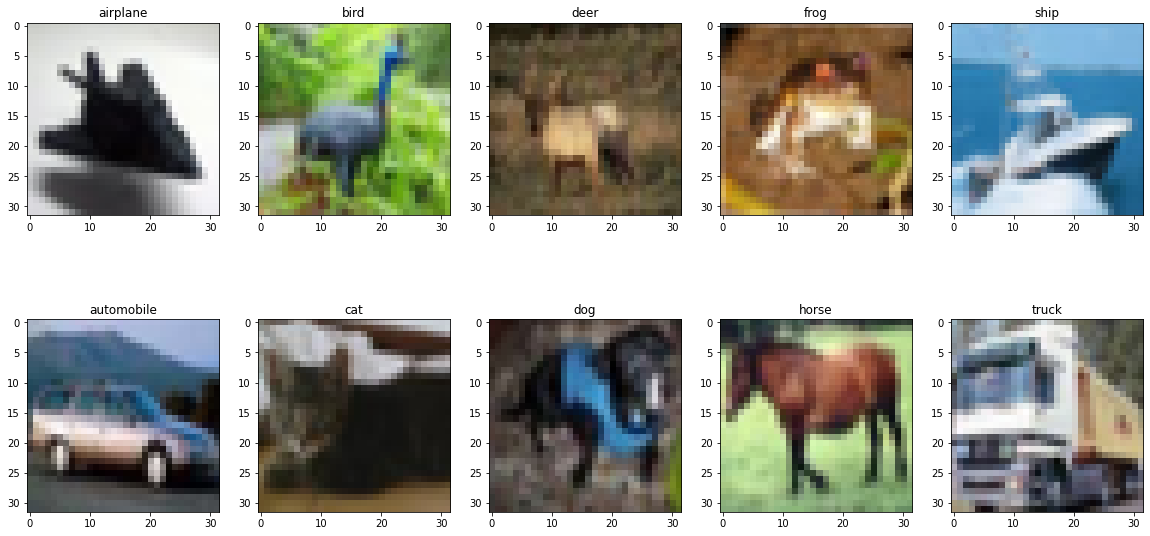

In [3]:
# visualize one example from each image class

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

for category_index in range(10):
  ri = category_index % 2
  ci = category_index // 2
  data_index = np.where(y_train==category_index)[0][0]  # get first image with correct label 
  ax[ri,ci].imshow(x_train[data_index])
  ax[ri,ci].set_title(labels[category_index])

In [4]:
# one-hot encoding labels
y_train = np.eye(10)[y_train.reshape(-1)]
y_test = np.eye(10)[y_test.reshape(-1)]

# standardize input data
x_train = tf.image.per_image_standardization(x_train)
x_test = tf.image.per_image_standardization(x_test)

# cast to float32 so that tf.nn.conv2d is happy
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_train = tf.cast(y_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)


# batch, shuffle, prefetch
def preprocess(input, label, batch_size=None, buffer_size=None, augment=False):
  '''
  zip separate input and label and do standard preprocessing
  :param input: np.array, input to network
  :param label: np.array, correct label in supervised learning
  :param batch_size: int, batch such that 100 updates per epoch in default
  :param buffer_size: int, max buff size in default
  :param augment: tf.keras.Sequential, layers to do data augmentation
  :returns: tf.dataset
  '''

  if batch_size == None:  
    batch_size = input.shape[0]//100
  if buffer_size == None:  
    buffer_size = input.shape[0] 

  dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(input),
                                 tf.data.Dataset.from_tensor_slices(label)))
  dataset = dataset.shuffle(buffer_size)  # shuffle before batch
  dataset = dataset.batch(batch_size)
  
  if augment:
    dataset = dataset.map(lambda x, y: (augment(x, training=True), y), 
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return dataset


# # define data augmentation processes
# data_augmentation_layer = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#                                                tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])


train_ds = preprocess(x_train, y_train, batch_size=64, augment=False)
test_ds = preprocess(x_test, y_test, batch_size=1, augment=False)

# 2. Model
https://medium.com/intelligentmachines/convolutional-neural-network-and-regularization-techniques-with-tensorflow-and-keras-5a09e6e65dc7

### Reg. design
- data augmentation: worsen the performance
- kernel reg l2 norm
- dropout
- batch norm

### architectural design
- Convolution: num.filter, size of kernel
- Pooling: when to pool, stride=(2,2)
- Dense: num. layers&units



In [5]:
# LAMBDA = 0.01  # reg param
# kern_reg = tf.keras.regularizers.l2(LAMBDA)
kern_reg = None

NUM_FILTER = 256
KERNEL_SIZE = (2,2)
NUM_DENSE = 2048

class CNN_reg(tf.keras.Model): 
  def __init__(self):
    super(CNN_reg, self).__init__()
    self.conv0 = tf.keras.layers.Conv2D(filters=NUM_FILTER,
                                        kernel_size=KERNEL_SIZE,
                                        kernel_regularizer=kern_reg,
                                        input_shape=(32,32,3)) 
    # self.batchnorm0 = tf.keras.layers.BatchNormalization()
    self.activation0 = tf.keras.activations.tanh  # ReLU might die?
   
    self.conv1 = tf.keras.layers.Conv2D(filters=NUM_FILTER,
                                        kernel_size=KERNEL_SIZE,
                                        kernel_regularizer=kern_reg)
    # self.batchnorm1 = tf.keras.layers.BatchNormalization()
    self.activation1 = tf.keras.activations.tanh

    self.conv2 = tf.keras.layers.Conv2D(filters=NUM_FILTER,
                                        kernel_size=KERNEL_SIZE,
                                        kernel_regularizer=kern_reg)
    # self.batchnorm2 = tf.keras.layers.BatchNormalization()
    self.activation2 = tf.keras.activations.tanh

    self.pool0 = tf.keras.layers.MaxPooling2D()

    self.conv3 = tf.keras.layers.Conv2D(filters=NUM_FILTER,
                                        kernel_size=KERNEL_SIZE,
                                        kernel_regularizer=kern_reg)
    # self.batchnorm3 = tf.keras.layers.BatchNormalization()
    self.activation3 = tf.keras.activations.tanh

    self.conv4 = tf.keras.layers.Conv2D(filters=NUM_FILTER,
                                        kernel_size=KERNEL_SIZE,
                                        kernel_regularizer=kern_reg)
    # self.batchnorm4 = tf.keras.layers.BatchNormalization()
    self.activation4 = tf.keras.activations.tanh

    self.conv5 = tf.keras.layers.Conv2D(filters=NUM_FILTER,
                                        kernel_size=KERNEL_SIZE,
                                        kernel_regularizer=kern_reg)
    # self.batchnorm5 = tf.keras.layers.BatchNormalization()
    self.activation5 = tf.keras.activations.tanh

    self.pool1 = tf.keras.layers.MaxPooling2D()

    self.flatten = tf.keras.layers.Flatten()
    
    # self.dropout0 = tf.keras.layers.Dropout(0.5) 
    self.dense0 = tf.keras.layers.Dense(NUM_DENSE,
                                        activation='tanh',
                                        kernel_regularizer=kern_reg)

    # self.dropout1 = tf.keras.layers.Dropout(0.5)
    self.dense1 = tf.keras.layers.Dense(NUM_DENSE,
                                        activation='tanh',
                                        kernel_regularizer=kern_reg)
    
    self.dropout2 = tf.keras.layers.Dropout(0.5)
    self.readout = tf.keras.layers.Dense(10,
                                         activation='softmax',
                                         kernel_regularizer=kern_reg)

  @tf.function
  def call(self, x, training=True):
    x = self.conv0(x)
    # x = self.batchnorm0(x, training)
    x = self.activation0(x)

    x = self.conv1(x)
    # x = self.batchnorm1(x, training)
    x = self.activation1(x)

    x = self.conv2(x)
    # x = self.batchnorm2(x, training)
    x = self.activation2(x)

    x = self.pool0(x)

    x = self.conv3(x)
    # x = self.batchnorm3(x, training)
    x = self.activation3(x)

    x = self.conv4(x)
    # x = self.batchnorm4(x, training)
    x = self.activation4(x)

    x = self.conv5(x)
    # x = self.batchnorm5(x, training)
    x = self.activation5(x)

    x = self.pool1(x)

    x = self.flatten(x)

    # x = self.dropout0(x, training)
    x = self.dense0(x)

    # x = self.dropout1(x, training)
    x = self.dense1(x)
    
    x = self.dropout2(x, training)
    x = self.readout(x)

    return x

# 3. Train


In [6]:
@tf.function
def train_step(model, input, target, loss_function, optimizer, acc_function):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training=True)  # for dropout/batchnorm
    loss = loss_function(target, prediction
                         ) + tf.reduce_sum(model.losses)  # reg. loss
    acc = acc_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, acc


def test(model, test_data, loss_function, acc_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input, training=False)  # for dropout/batchnorm
    test_loss_aggregator.append(loss_function(target, prediction))
    test_accuracy_aggregator.append(acc_function(target, prediction))
  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy


# function for computing running avg
RA_FACTOR = 0.95
compute_RA = lambda x, current_avg: RA_FACTOR * current_avg  + (1-RA_FACTOR) * x

Epoch: __ 0


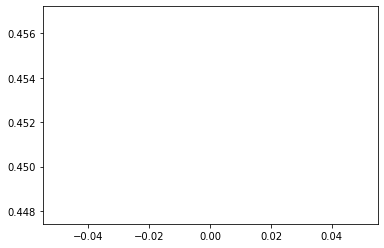

Epoch: __ 1


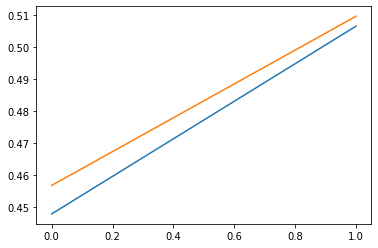

Epoch: __ 2


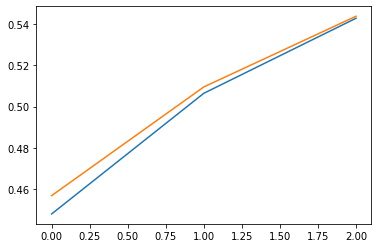

Epoch: __ 3


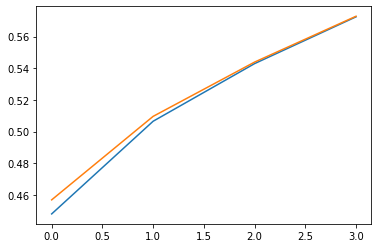

Epoch: __ 4


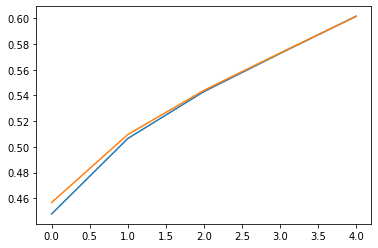

Epoch: __ 5


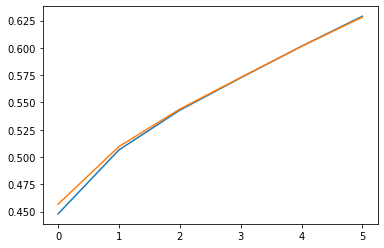

Epoch: __ 6


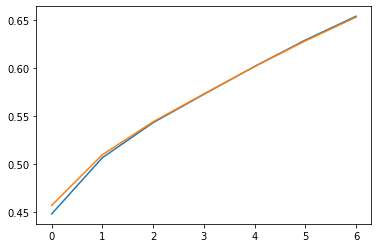

Epoch: __ 7


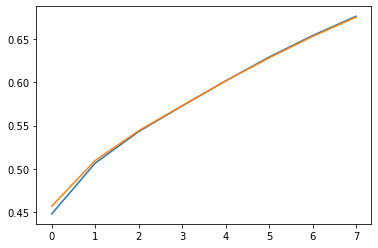

Epoch: __ 8


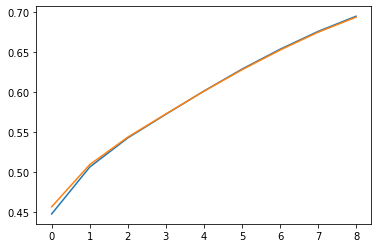

Epoch: __ 9


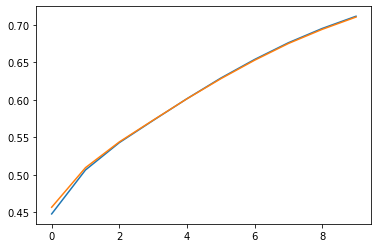

Epoch: __ 10


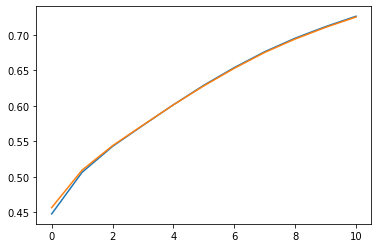

Epoch: __ 11


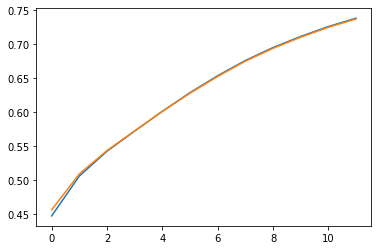

Epoch: __ 12


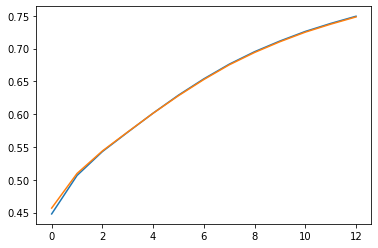

Epoch: __ 13


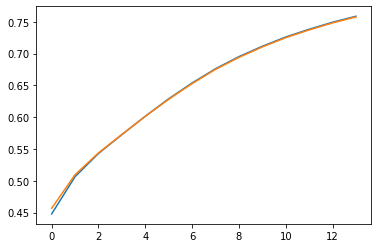

Epoch: __ 14


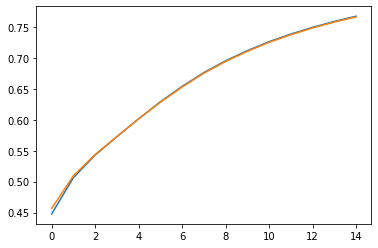

Epoch: __ 15


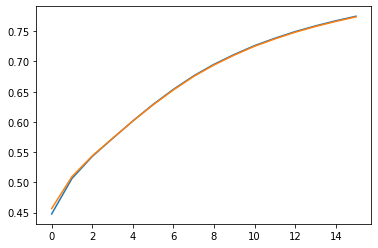

Epoch: __ 16


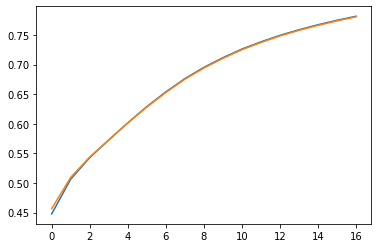

Epoch: __ 17


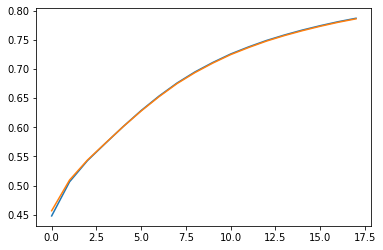

Epoch: __ 18


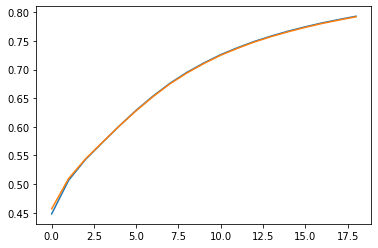

Epoch: __ 19


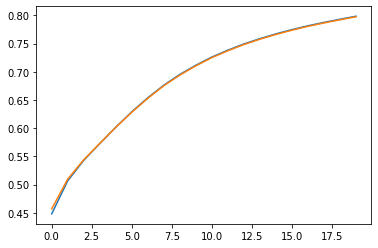

Epoch: __ 20


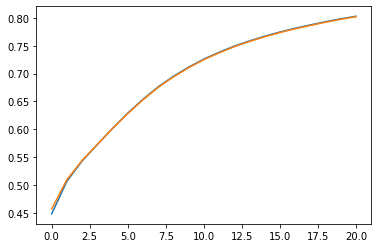

Epoch: __ 21


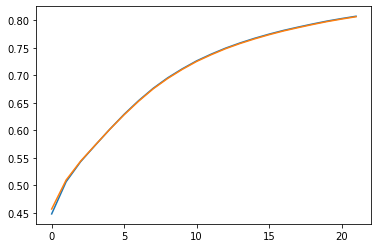

Epoch: __ 22


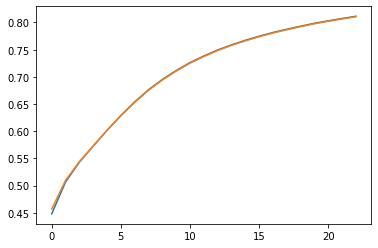

Epoch: __ 23


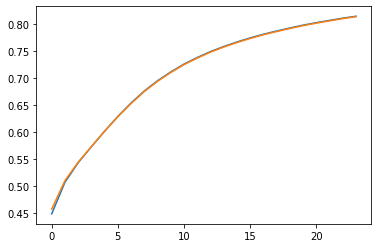

Epoch: __ 24


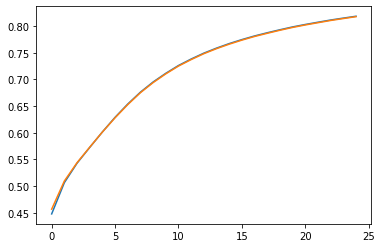

Epoch: __ 25


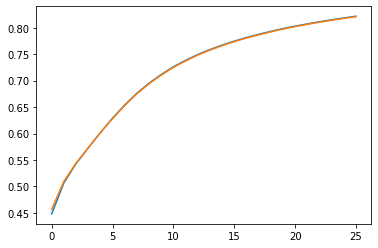

Epoch: __ 26


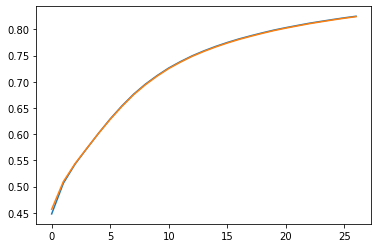

Epoch: __ 27


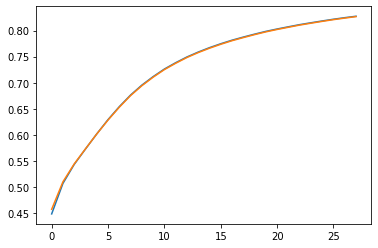

Epoch: __ 28


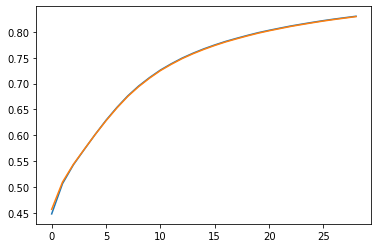

Epoch: __ 29


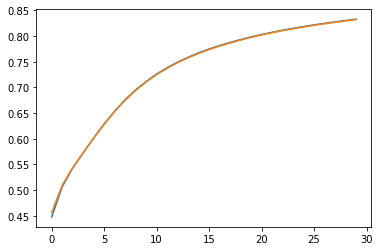

Epoch: __ 30


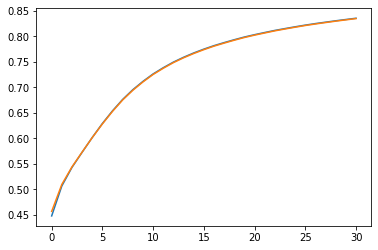

Epoch: __ 31


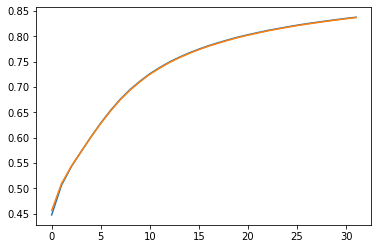

Epoch: __ 32


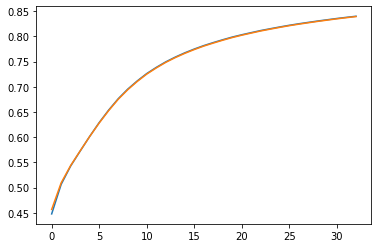

Epoch: __ 33


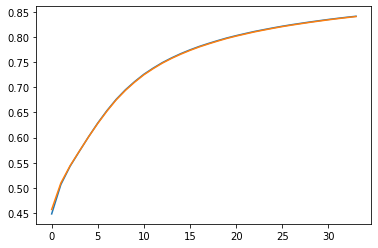

Epoch: __ 34


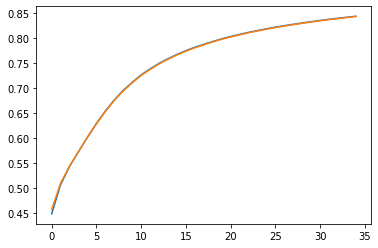

Epoch: __ 35


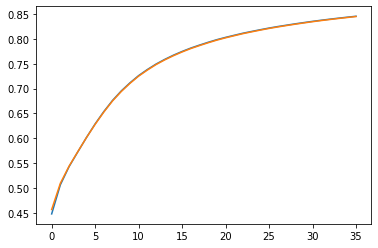

Epoch: __ 36


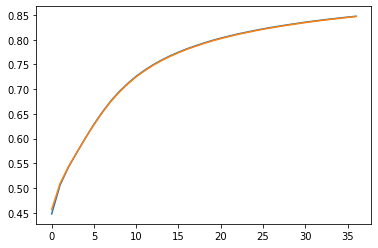

Epoch: __ 37


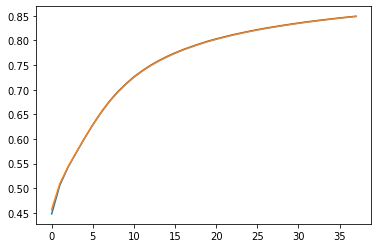

Epoch: __ 38


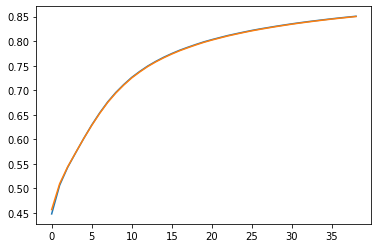

Epoch: __ 39


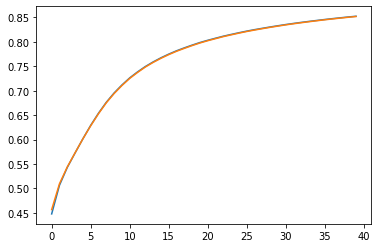

In [7]:
tf.keras.backend.clear_session()

### Hyperparameters
NUM_EPOCHS = 40
LEARNING_RATE = 0.0001

# Initialize the model.
model = CNN_reg()
loss_f = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
acc_f = tf.keras.metrics.CategoricalAccuracy()

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(NUM_EPOCHS):
  print('Epoch: __ ' + str(epoch))

  #training (and checking in with training)
  loss_ra = 0
  acc_ra = 0
  for (input,target) in train_ds:
    train_loss, train_acc = train_step(model, input, target, loss_f, optimizer, acc_f)
    loss_ra = compute_RA(train_loss, loss_ra)
    acc_ra = compute_RA(train_acc, acc_ra)
  # append running averaged results after each epoch
  train_losses.append(compute_RA(train_loss, loss_ra))
  train_accuracies.append(compute_RA(train_acc, acc_ra))

  #testing
  test_loss, test_accuracy = test(model, test_ds, loss_f, acc_f)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # plot 
  plt.plot(train_accuracies)
  plt.plot(test_accuracies)
  plt.pause(5)

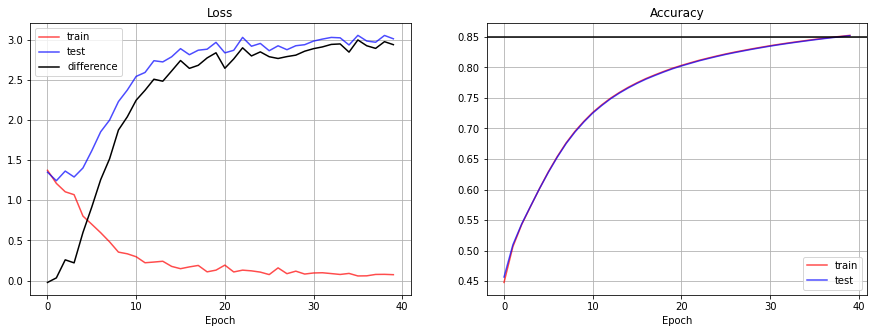

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax[0].plot(train_losses, label='train', color='red', alpha=0.7)
ax[0].plot(test_losses, label='test', color='blue', alpha=0.7)
ax[0].plot(np.array(test_losses) - np.array(train_losses), label='difference', color='black')
ax[0].grid()

ax[0].legend()
ax[0].set(xticks=[0,10,20,30,40], xlabel='Epoch', title='Loss')

ax[1].plot(train_accuracies, label='train', color='red', alpha=0.7)
ax[1].plot(test_accuracies, label='test', color='blue', alpha=0.7)
ax[1].axhline(y=0.85, color='black')
ax[1].grid()

ax[1].legend()
ax[1].set(xticks=[0,10,20,30,40], xlabel='Epoch', title='Accuracy')

plt.show()